In [1]:
import pandas as pd
import numpy as np
import os
import random
import shutil  
import urllib.request
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import models
from keras.datasets import cifar10
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Activation, Flatten, Conv2D
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from keras.preprocessing.image import ImageDataGenerator
import zipfile
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
url = "http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip"
urllib.request.urlretrieve(url, 'dataset.zip')

with zipfile.ZipFile("/content/dataset.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [0]:
train_path ='/content/data/UCMerced_LandUse/Images'
os.mkdir('/content/data/UCMerced_LandUse/test')
os.mkdir('/content/data/UCMerced_LandUse/validation')
validation_path = '/content/data/UCMerced_LandUse/validation'
test_path  = '/content/data/UCMerced_LandUse/test'

train_folders = os.listdir(train_path)
validation_folders = os.listdir(validation_path)
test_folders = os.listdir(test_path)

In [4]:
for folder in train_folders:
    if folder != ".DS_Store":
        current_path = os.path.join(train_path,folder)
        files = os.listdir(current_path)
        files_to_move = files[-15:]
        v_destination = (os.path.join(validation_path, folder))
        t_destination = (os.path.join(test_path, folder))

        file_counter = 0
        for file in files_to_move:
            if file_counter <= 10:
              source = os.path.join(current_path,file)
              print(source)
              if os.path.exists(v_destination):
                dest = shutil.copy(source, v_destination)
                os.remove(source)
                print(source, "moved to" , v_destination)
                file_counter = file_counter + 1
              else:
                os.mkdir(v_destination)
                dest = shutil.copy(source, v_destination)
                os.remove(source)
                print(source, "moved to" , v_destination)
                file_counter = file_counter + 1
            else:
              source = os.path.join(current_path,file)
              print(source)
              if os.path.exists(t_destination):
                dest = shutil.copy(source, t_destination)
                os.remove(source)
                print(source, "moved to" , t_destination)
                file_counter = file_counter + 1
              else:
                os.mkdir(t_destination)
                dest = shutil.copy(source, t_destination)
                os.remove(source)
                print(source, "moved to" , t_destination)
                file_counter = file_counter + 1


/content/data/UCMerced_LandUse/Images/freeway/freeway33.tif
/content/data/UCMerced_LandUse/Images/freeway/freeway33.tif moved to /content/data/UCMerced_LandUse/validation/freeway
/content/data/UCMerced_LandUse/Images/freeway/freeway05.tif
/content/data/UCMerced_LandUse/Images/freeway/freeway05.tif moved to /content/data/UCMerced_LandUse/validation/freeway
/content/data/UCMerced_LandUse/Images/freeway/freeway50.tif
/content/data/UCMerced_LandUse/Images/freeway/freeway50.tif moved to /content/data/UCMerced_LandUse/validation/freeway
/content/data/UCMerced_LandUse/Images/freeway/freeway62.tif
/content/data/UCMerced_LandUse/Images/freeway/freeway62.tif moved to /content/data/UCMerced_LandUse/validation/freeway
/content/data/UCMerced_LandUse/Images/freeway/freeway63.tif
/content/data/UCMerced_LandUse/Images/freeway/freeway63.tif moved to /content/data/UCMerced_LandUse/validation/freeway
/content/data/UCMerced_LandUse/Images/freeway/freeway45.tif
/content/data/UCMerced_LandUse/Images/freeway

In [5]:
# Path to the train folder
original_test = '/content/data/UCMerced_LandUse/test'
categories = os.listdir(original_test)
files_list = []
categories_list = []
for category in categories:
   category_path = os.path.join(original_test,category)

   files = os.listdir(category_path)
   for file_name in files:
     files_list.append(str(category) + "/" + file_name)
     categories_list.append(category)

print(len(files_list))
print(len(categories_list))
data_test = pd.DataFrame({'filename':files_list,'label':categories_list})

data_test.to_csv("original_test.csv",index=False)

84
84


data augmentation is used. The below cell is also serving the purpose of creating data generator which will later be fed into the model


In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    directory=r"/content/data/UCMerced_LandUse/Images",
    target_size=(70, 70),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_generator = test_datagen.flow_from_directory(
    directory=r"/content/data/UCMerced_LandUse/validation",
    target_size=(70, 70),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory="/content/data/UCMerced_LandUse/test",
    target_size=(70, 70),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 1785 images belonging to 21 classes.
Found 231 images belonging to 21 classes.
Found 84 images belonging to 21 classes.


The hyper parameters in this model are mostly default. 
The convolutional layes contain 32 nodes and use a filter of (3,3)
The learning rate is default (0.01)
The loss is categorical crossentropy
The optimizer used is adam

In [7]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


model = Sequential() #model = sequential 
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(70,70,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten()) #make layer flatten
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(21, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Model Summary

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)         

loss vs epochs and accuracy vs epochs - on train and validation

In [9]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/25





55/55 [==============================] - 17s 303ms/step - loss: 3.0119 - acc: 0.0528 - val_loss: 2.9106 - val_acc: 0.0714
Epoch 2/25
55/55 [==============================] - 3s 61ms/step - loss: 2.7590 - acc: 0.1319 - val_loss: 2.7603 - val_acc: 0.1709
Epoch 3/25
55/55 [==============================] - 3s 59ms/step - loss: 2.5260 - acc: 0.2034 - val_loss: 2.4624 - val_acc: 0.1709
Epoch 4/25
55/55 [==============================] - 3s 59ms/step - loss: 2.4195 - acc: 0.2271 - val_loss: 2.1156 - val_acc: 0.2714
Epoch 5/25
55/55 [==============================] - 3s 60ms/step - loss: 2.2361 - acc: 0.2780 - val_loss: 2.0266 - val_acc: 0.3367
Epoch 6/25
55/55 [==============================] - 3s 59ms/step - loss: 2.1074 - acc: 0.3050 - val_loss: 1.9607 - val_acc: 0.3467
Epoch 7/25
55/55 [==============================] - 3s 61ms/step - loss: 2.0132 - acc: 0.3438 - val_loss: 1.97

Making Predictions on the Test Set

In [13]:
import pandas as pd

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class_indices = []
for i in pred:
        predicted_class_indices.append(np.argmax(np.asarray(i)))

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

84/84 [==============================] - 0s 2ms/step


Creating a Final Dataframe which contains the test file names, the actual label and the predicted label

In [0]:
final_pred_df = pd.DataFrame(columns = ["filename", "label","pred"])
filename_list = []
label_list = []
pred_list = []

for filename in results["Filename"]:
  # print(filename)
  filename_list.append(filename)
  label_list.append(data_test[data_test["filename"] == filename]["label"].values[0])
  pred_list.append(results[results["Filename"] == filename]["Predictions"].values[0])

final_pred_df["filename"] = filename_list
final_pred_df["label"] = label_list
final_pred_df["pred"] = pred_list
final_pred_df.to_csv("final.csv")

Creating the confusion Matrix

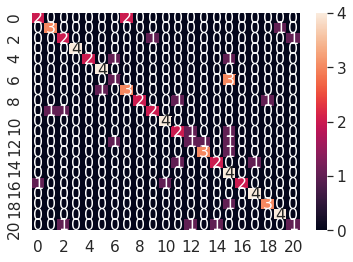

In [12]:
cm=confusion_matrix(final_pred_df['label'],final_pred_df['pred'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()